In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
tfk = tf.keras
tfkl = tf.keras.layers
from tensorflow.keras.mixed_precision import experimental as mixed_precision

In [2]:
policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
mixed_precision.set_policy(policy)


In [3]:
N = 512
datadir = '/global/cscratch1/sd/tmedan/notebooks/'


In [4]:

class ScaleField(): 
    # used min-max scaling HERE ONLY 
    def __init__(self, field):
        super(ScaleField, self).__init__()

        self.fmin  = field.min()
        self.fmax  = field.max() 
        self.fmean = field.mean()
    
    def scale(self, field, inv=False): 
        if not inv:
            self.scaled = True
            return (field - self.fmin) / (self.fmax - self.fmin)
        if inv:
            self.scaled = False
            return field * (self.fmax - self.fmin) + self.fmin


In [5]:
def cubify(arr, newshape):
    '''stolen from https://stackoverflow.com/questions/42297115/numpy-split-cube-into-cubes'''
    oldshape = np.array(arr.shape)
    repeats = (oldshape / newshape).astype(int)
    tmpshape = np.column_stack([repeats, newshape]).ravel()
    order = np.arange(len(tmpshape))
    order = np.concatenate([order[::2], order[1::2]])
    
    # newshape must divide oldshape evenly or else ValueError will be raised
    return arr.reshape(tmpshape).transpose(order).reshape(-1, *newshape)

def uncubify(arr, oldshape):
    '''stolen from https://stackoverflow.com/questions/42297115/numpy-split-cube-into-cubes'''
    N, newshape = arr.shape[0], arr.shape[1:]
    oldshape = np.array(oldshape)    
    repeats = (oldshape / newshape).astype(int)
    tmpshape = np.concatenate([repeats, newshape])
    order = np.arange(len(tmpshape)).reshape(2, -1).ravel(order='F')
    return arr.reshape(tmpshape).transpose(order).reshape(oldshape)

In [6]:
def identity_block(X, filters):
    
    F1, F2, F3 = filters
     
    X_shortcut = X
    
    #first part
    X = tfkl.Conv3D(filters = F1, kernel_size = (5,5,5), strides = (1,1,1), padding = 'same')(X)
    X = tfkl.BatchNormalization()(X)
    X = tfkl.Activation('relu')(X)
    
    
    #second part
    X = tfkl.Conv3D(filters = F2, kernel_size = (5,5,5), strides = (1,1,1), padding = 'same')(X)
    X = tfkl.BatchNormalization()(X)
    X = tfkl.Activation('relu')(X)

    #third part 
    X = tfkl.Conv3D(filters = F3, kernel_size = (5,5,5), strides = (1,1,1), padding = 'same')(X)
    X = tfkl.BatchNormalization()(X)

    # add the shortcut identity to the main blocks 
    X = tfkl.Add()([X, X_shortcut])
    X = tfkl.Activation('relu')(X)
    
    return X


def convolutional_block(X, f, filters):

    
    F1, F2, F3 = filters
    
    
    X_shortcut = X

    X = tfkl.Conv3D(F1, kernel_size = (5,5,5), strides = (1,1,1),padding = 'same')(X)
    X = tfkl.BatchNormalization()(X)
    X = tfkl.Activation('relu')(X)
    
 
    X = tfkl.Conv3D(F2, kernel_size = (f,f,f), strides = (1,1,1), padding = 'same')(X)
    X = tfkl.BatchNormalization()(X)
    X = tfkl.Activation('relu') (X)

     
    X = tfkl.Conv3D(F3, kernel_size = (5,5,5), strides = (1,1,1), padding = 'same')(X)
    X = tfkl.BatchNormalization()(X)

    
    X_shortcut = tfkl.Conv3D(F3, kernel_size = (5,5,5), strides = (1,1,1), padding = 'same')(X_shortcut)
    X_shortcut = tfkl.BatchNormalization()(X_shortcut)

    #add shortcut value to main path
    X = tfkl.Add()([X, X_shortcut])
    X = tfkl.Activation('relu')(X)
    
    
    return X


img_shape = 32

Input_shape=(img_shape,img_shape,img_shape,1)

def VNet(input_shape = Input_shape, classes = 3):
    
    X_input = tfkl.Input(Input_shape)

    #X = tfkl.ZeroPadding3D(padding=(3,3,3))(X_input)
    
    X = tfkl.BatchNormalization()(X_input)
    
    X = tfkl.Conv3D(filters = 12, kernel_size = (5,5,5), strides = (1,1,1), padding = 'same')(X)
    X = tfkl.BatchNormalization()(X)
    X = tfkl.Activation('relu')(X)
    
    X = convolutional_block(X, f = 5, filters = [12,12,12])
    X = identity_block(X, [12,12,12])
    X = identity_block(X, [12,12,12])

    X = tfkl.MaxPooling3D((2,2,2),strides=(2,2,2))(X)

     
    X = convolutional_block(X, f = 5, filters = [24,24,24])
    X = identity_block(X, [24,24,24])
    X = identity_block(X, [24,24,24])
    X = identity_block(X, [24,24,24])

     
    X = convolutional_block(X, f = 5, filters = [24,24,24])
    X = identity_block(X, [24,24,24])
    X = identity_block(X, [24,24,24])
    X = identity_block(X, [24,24,24])
    X = identity_block(X, [24,24,24])
    X = identity_block(X, [24,24,24])

     
    X = convolutional_block(X, f = 3, filters = [24,24,24])
    X = identity_block(X, [24,24,24])
    X = identity_block(X, [24,24,24])

    #transpose back to input shape due to maxpooling downsizing
    X = tfkl.Conv3DTranspose(filters = 48,kernel_size =(2,2,2),strides = (2,2,2),padding = 'same' )(X)
    X = tfkl.BatchNormalization()(X)
    X = tfkl.Activation('relu')(X)
    
    # output layer
    X = tfkl.Conv3D(filters=1,
                      kernel_size=(1,1,1),
                      strides=(1,1,1),
                      padding= 'same')(X)
    
    model = tfk.models.Model(inputs = X_input, outputs = X)
    
    optimizer = tfk.optimizers.Adam(1e-2)
    
    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['mae'])

    return model

In [6]:
#training data

def data_feeder(n_files, img_shape):
    sim_size  =  512
    n_subcube = int((sim_size//img_shape)**3)
    # make empty array first.
    densE = np.zeros((n_files, n_subcube, img_shape, img_shape, img_shape))
    densL = np.zeros((n_files, n_subcube, img_shape, img_shape, img_shape))
    reion = np.zeros((n_files, n_subcube, img_shape, img_shape, img_shape))
    for i in range(n_files):
        # load in simulation
        densEfile_i = datadir+'density_Eul/dens_{:02d}'.format(i)
        densE_i = np.fromfile(open(densEfile_i),count=sim_size**3,dtype=np.float32).reshape(sim_size, sim_size, sim_size)
        
        densLfile_i = datadir+'density_Lag/dens_{:02d}'.format(i)
        densL_i = np.fromfile(open(densLfile_i),count=sim_size**3,dtype=np.float32).reshape(sim_size, sim_size, sim_size)
        
        reionfile_i = datadir+'reionization/reion_{:02d}'.format(i)
        reion_i = np.fromfile(open(reionfile_i),count=sim_size**3,dtype=np.float32).reshape(sim_size, sim_size, sim_size)
        #reshape to subcubes
        densE[i] = cubify(densE_i,(img_shape,img_shape,img_shape))
        densL[i] = cubify(densL_i,(img_shape,img_shape,img_shape))
        reion[i] = cubify(reion_i,(img_shape,img_shape,img_shape))
    # add additional axis for number of channels
    densE = densE[..., np.newaxis]
    densL = densL[..., np.newaxis]
    reion = reion[..., np.newaxis]
    # scale all fields at once
    densE = ScaleField(densE).scale(field=densE)
    densL = ScaleField(densL).scale(field=densL)
    reion = ScaleField(reion).scale(field=reion)
    return densE,densL,reion

data = data_feeder(3,32)
densE_train = data[0]
densL_train = data[1]
reion_train = data[2]

In [7]:
model = VNet() 

model.summary()
print(len(model.layers))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 32,  0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 32, 1 4           input_1[0][0]                    
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 32, 32, 32, 1 1512        batch_normalization[0][0]        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 32, 1 48          conv3d[0][0]                     
______________________________________________________________________________________________

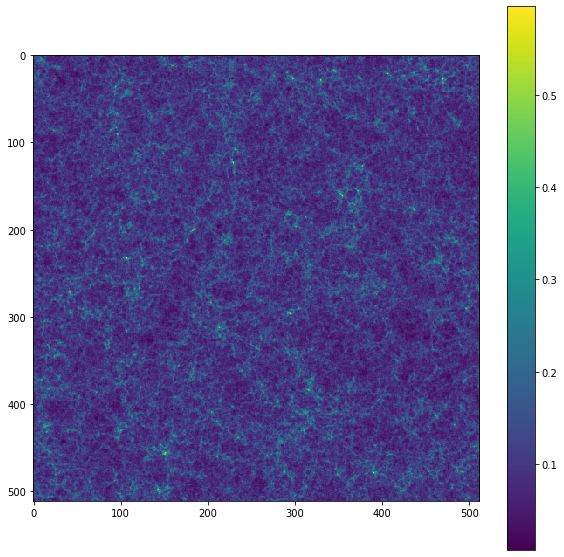

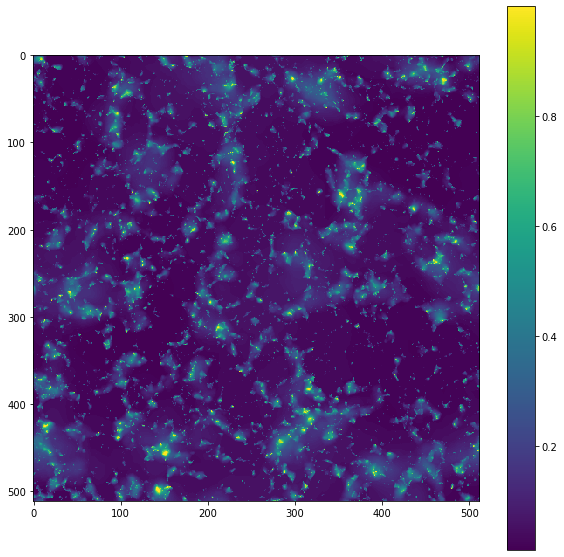

In [8]:
# get test data

freion = open(datadir+'reionization/reion_05')
fdens  = open(datadir+'density_Eul/dens_05')

x_test  = np.fromfile(fdens, count=N**3, dtype=np.float32).reshape(N,N,N)
y_test  = np.fromfile(freion, count=N**3, dtype=np.float32).reshape(N,N,N)


x_test = ScaleField(x_test).scale(field=x_test)
y_test = ScaleField(y_test).scale(field=y_test)


plt.figure(figsize=(10,10))
plt.imshow(x_test[0])
plt.colorbar()

plt.figure(figsize=(10,10))
plt.imshow(y_test[0])
plt.colorbar()

x_test = cubify(x_test,  (img_shape, img_shape, img_shape))[..., np.newaxis]
y_test = cubify(y_test,  (img_shape, img_shape, img_shape))[..., np.newaxis]

reion_test  = ScaleField(y_test).scale(field=y_test,inv=True)

In [ ]:
for i in range(densE_train.shape[0]):
    history = model.fit(densE_train[i],reion_train[i],
                    epochs=2,
                    validation_split=0.1)
    
'''submit for one hour
use cori gpu submission 
through srun
'''

In [ ]:

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.xscale('log')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('V-net_trainplot')
plt.show()

In [17]:
model.save('V-net')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: Resnet50/assets


In [11]:
y_test_predict = model.predict(x_test)

reion_test_predict = ScaleField(y_test_predict).scale(field = y_test_predict, inv=True)

In [12]:
yshow_predict = reion_test_predict[0,img_shape//2, ..., 0]
yshow = reion_test[0,img_shape//2, ..., 0]
xshow = x_test[0,img_shape//2, ..., 0]

ymin = yshow.min()
ymax = yshow.max()

In [ ]:
plt.scatter(yshow.flatten(),yshow_predict.flatten(),c='k',s=0.5)
xx = np.linspace(yshow.min(), yshow.max(), 100)
plt.plot(xx,xx, 'k')

In [ ]:
plt.figure()
plt.imshow(yshow_predict, vmin = ymin, vmax=ymax)
plt.colorbar()
plt.title('V-Net Prediction')
plt.savefig('V-Net_predict')

plt.figure()
plt.imshow(yshow, vmin = ymin, vmax=ymax)
plt.colorbar()
plt.title('Actual 21CM Run')
plt.savefig('V-Net_actual')

diff = yshow_predict-yshow
plt.figure()
plt.imshow(diff, vmin=-np.abs(diff).max(), vmax=np.abs(diff).max(), cmap=plt.get_cmap('coolwarm'))
plt.colorbar()
plt.title('V-Net Difference')
plt.savefig('V-Net_diff')
